In [2]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import matplotlib.pyplot as plt 
from string import punctuation

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [5]:
playlist = pd.read_csv('pre_total_playlist.csv')

## 불용어

In [6]:
# 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']
# 우리 , 그대 , 사랑 , 지금

In [7]:
len(stop_w)

120

## 신조어

In [9]:
len(add_words)

236

In [10]:
from ckonlpy.tag import Twitter
twitter = Twitter()

In [11]:
# 리스트에 담긴 단어만큼 사전에 추가
for i in range(len(add_words)):
    twitter.add_dictionary(add_words[i], 'Noun')

## 토큰화

In [12]:
word_list = playlist['Lyric'].apply(lambda x: [word for word in twitter.nouns(x) if word not in stop_w])

In [13]:
word_list

0        [아무, 리, 바보, 울, 곁, 상처, 기, 다리, 란, 보고, 보고, 만큼, 울,...
1        [그대, 란, 사람, 허락, 맘, 그대, 때문, 란, 눈길, 줄, 만큼, 다만, 가...
2        [어쩌면, 오늘이, 마지막, 지도, 사랑, 불안, 마음, 니, 눈, 마주, 치, 사...
3        [술, 잔, 생각, 밤, 시절, 모두, 한숨, 그대, 얼굴, 혹시, 울, 지나, 먼...
4        [손짓, 목소리, 마음, 지도, 맘대로, 나라, 사랑, 행복, 맘, 프라, 가기, ...
                               ...                        
15337    [언제, 익숙, 매일, 반복, 하루, 연속, 모습, 어가, 거울, 얼굴, 위로, 주...
15338    [옛날, 옛적, 서울, 이란, 곳, 구월, 손톱, 구월, 구월, 기, 금, 간, 발...
15339    [일로, 전화, 술, 시간, 사실, 취하, 거, 우리, 안, 만해, 남아, 전화, ...
15340    [원래, 별, 뜻, 다정, 생각, 향, 길이, 중이, 언제, 순간, 가득, 차, 오...
15341    [아침, 진, 꽤, 거, 늦, 어도, 래서, 남, 맘, 아침, 선택, 사항, 사이,...
Name: Lyric, Length: 15342, dtype: object

## 벡터화

* min_df : 단어장에 포함되기 위한 최소 빈도
* max_df : 단어장에 포함되기 위한 최대 빈도
* ngram_range : 튜플 (min_n, max_n) n-그램 범위

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 설정해준 카테고리의 데이터들만 추출
# CountVectorizer로 텍스트 데이터들 단어 빈도수에 기반해 벡터화시키기(fit_transform)
count_vect = CountVectorizer(max_df=0.95, max_features=1000,
                            min_df=2, stop_words=stop_w,
                            ngram_range=(1,5)) 
ftr_vect = count_vect.fit_transform(word_list.astype(str))


## 토픽 모델링

In [15]:
# LDA클래스를 이용해서 피처 벡터화시킨 것을 토픽모델링 시키기
# n_components(토픽개수) 5로 설정
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(ftr_vect)
# components_속성은 5개의 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)

(5, 1000)
[[9.38755892e+00 1.68365196e+01 1.27075393e+02 ... 8.95794142e-01
  1.26853010e+01 2.06849217e-01]
 [9.98509240e+00 1.13408447e+01 3.60979456e+01 ... 5.22551092e+01
  4.50649210e+01 3.08047800e+01]
 [7.21517970e+01 1.90329006e+02 1.52640965e+02 ... 3.63290230e+01
  2.81221732e+00 1.07670516e+01]
 [5.31793062e+01 1.42749113e+02 5.33940846e+01 ... 2.28631804e+01
  2.75807453e+02 9.51512308e+00]
 [1.52962454e+01 6.07445167e+01 3.94791612e+02 ... 9.76568933e+01
  2.96301074e+01 1.04706196e+02]]


In [16]:
# transform까지 수행하면, 문서별(row)로 토픽들(column)의 분포를 알려줌
doc_topics = lda.transform(ftr_vect)
print(doc_topics.shape)
print(doc_topics[:2]) # 두 곡에 대한 확률 정보

(15342, 5)
[[0.00481678 0.98060314 0.00483275 0.00495786 0.00478947]
 [0.47385169 0.51121271 0.00494518 0.00503336 0.00495707]]


## 토픽 별 주요 단어

In [17]:
def display_topic_words(lda_model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print('\nTopic #', topic_idx+1)
        
        # Topic별로 1000개의 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌

        topic_word_idx = topic.argsort()[::-1] # argsort()는 디폴트가 오름차순, [::-1]로 내림차순 변경
        top_idx = topic_word_idx[:num_top_words]
        
        # CountVectorizer함수 할당시킨 객체에 get_feature_names()로 벡터화시킨 feature(단어들)볼 수 있음
        # 이 벡터화시킨 단어들(features)은 숫자-알파벳순으로 정렬되며, 단어들 순서는 fit_transform시키고 난 이후에도 동일!
        # '문자열'.join 함수로 특정 문자열 사이에 끼고 문자열 합쳐줄 수 있음.
        feature_concat = '+'.join([str(feature_names[i])+'*'+str(round(topic[i], 1)) for i in top_idx])
        print(feature_concat)        
        
feature_names = count_vect.get_feature_names()
display_topic_words(lda, feature_names, 15)


Topic # 1
그대*14823.9+사랑*5522.4+어요*3186.0+마음*1659.7+당신*1493.1+사랑 사랑*1116.5+그대 그대*1017.2+다가*881.9+그대 사랑*830.0+사랑 그대*796.2+오늘*711.0+가요*702.0+언제*659.9+사랑 사랑 사랑*608.3+그대만*602.1

Topic # 2
사랑*18068.2+사람*4893.7+눈물*3181.5+행복*2750.7+우리*2606.0+이별*2031.7+마음*1821.3+가슴*1760.8+세상*1734.9+아직*1689.4+미안*1373.2+바보*1347.1+만큼*1327.1+기억*1259.2+사랑 사랑*1189.9

Topic # 3
지금*3609.4+매일*2358.5+어디*2248.0+생각*2202.0+오늘*1944.7+우리*1876.7+아무*1849.9+필요*1738.0+자꾸*1642.9+다른*1434.4+기분*1343.9+다가*1324.7+나나*1271.2+계속*1270.0+사람*1201.2

Topic # 4
우리*7037.6+시간*5321.1+오늘*5081.7+생각*4647.4+하루*4067.9+기억*3852.8+마음*3803.1+아무*3772.1+지나*3323.1+그때*2282.1+혼자*2207.4+조금*2023.6+아직*1978.3+보고*1795.9+내일*1776.8

Topic # 5
하늘*3075.0+순간*2623.1+아름*2542.7+바람*2524.8+세상*2475.4+우리*2089.0+가득*1664.2+지금*1584.0+노래*1519.4+다운*1390.2+아름 다운*1287.2+아래*1204.3+마음*1203.6+바다*1145.2+소리*1131.2


## 가장 높은 확률의 토픽만 추출

In [18]:
# 문서별로, 가장 확률이 높은 topic으로 할당해줌

doc_topic = lda.transform(ftr_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])
    
doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])

doc_topic_df.head()

,Doc_Num,Topic,Percentage
0,0,1,0.980603
1,1,1,0.511213
2,2,1,0.813000
3,3,0,0.368070
4,4,1,0.943660


## 노래 별 토픽 확률

In [20]:
# 주어진 내장 텍스트데이터의 문서이름에는 카테고리가 labeling되어있음. 
# 따라서, 카테고리가 무엇인지 아는 상태이니까 어떤 문서들이 어떤 토픽들이 높은지 확인해보자.
# 그리고 그 토픽들이 각각 무엇을 내용으로 하는지 추측해보자.
# 주어진 데이터셋의 filename속성을 이용해서 카테고리값들 가져오기
def get_filename_list(playlist):
    filename_lst = []
    for file in playlist.song_name: 
        filename_temp = file.split('/')[-2:]
        filename = '.'.join(filename_temp)
        filename_lst.append(filename)
    return filename_lst
 
filename_lst = get_filename_list(playlist)
# Dataframe형태로 만들어보기
topic_names = ['Topic #'+ str(i) for i in range(1,6)]
topic_df = pd.DataFrame(data=doc_topics, columns=topic_names,
                       index=filename_lst)

topic_df.head()

,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5
보고 싶다,0.004817,0.980603,0.004833,0.004958,0.004789
사랑합니다...,0.473852,0.511213,0.004945,0.005033,0.004957
어쩌면...,0.118988,0.813000,0.002145,0.063787,0.002080
소주 한 잔,0.368070,0.296772,0.062589,0.268677,0.003892
With Me,0.003311,0.943660,0.046338,0.003296,0.003395


## Topic # 1
그대*14823.9+사랑*5522.4+어요*3186.0+마음*1659.7+당신*1493.1+사랑 사랑*1116.5+그대 그대*1017.2+다가*881.9+그대 사랑*830.0+사랑 그대*796.2+오늘*711.0+가요*702.0+언제*659.9+사랑 사랑 사랑*608.3+그대만*602.1

## Topic # 2
사랑*18068.2+사람*4893.7+눈물*3181.5+행복*2750.7+우리*2606.0+이별*2031.7+마음*1821.3+가슴*1760.8+세상*1734.9+아직*1689.4+미안*1373.2+바보*1347.1+만큼*1327.1+기억*1259.2+사랑 사랑*1189.9

## Topic # 3
지금*3609.4+매일*2358.5+어디*2248.0+생각*2202.0+오늘*1944.7+우리*1876.7+아무*1849.9+필요*1738.0+자꾸*1642.9+다른*1434.4+기분*1343.9+다가*1324.7+나나*1271.2+계속*1270.0+사람*1201.2

## Topic # 4
우리*7037.6+시간*5321.1+오늘*5081.7+생각*4647.4+하루*4067.9+기억*3852.8+마음*3803.1+아무*3772.1+지나*3323.1+그때*2282.1+혼자*2207.4+조금*2023.6+아직*1978.3+보고*1795.9+내일*1776.8

## Topic # 5
하늘*3075.0+순간*2623.1+아름*2542.7+바람*2524.8+세상*2475.4+우리*2089.0+가득*1664.2+지금*1584.0+노래*1519.4+다운*1390.2+아름 다운*1287.2+아래*1204.3+마음*1203.6+바다*1145.2+소리*1131.2

## 가장 높은 확률의 토픽

In [21]:
# 문서별로, 가장 확률이 높은 topic으로 할당해줌

doc_topic = lda.transform(ftr_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])
    
doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])

doc_topic_df.head()

,Doc_Num,Topic,Percentage
0,0,1,0.980603
1,1,1,0.511213
2,2,1,0.813000
3,3,0,0.368070
4,4,1,0.943660


In [22]:
playlist.head(1) # 기본 곡 정보

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words
0,418253,보고 싶다,김범수,3rd. 보고 싶다,342238,아무리 기다려도 난 못가 바보처럼 울고 있는 너의 곁에 상처만 주는 나를 왜 ...,https://image.bugsm.co.kr/album/images/200/262...,"['국내', '가요', '발라드한', '발라드', '국내 발라드', '가을', '쓸...","['아무리', '기다려도', '난', '못가', '바보처럼', '울고', '있는',..."


In [23]:
doc_topic_df = doc_topic_df.join(playlist,lsuffix='index') # 병합
doc_topic_df.drop('Doc_Num', axis=1,inplace=True)
doc_topic_df.head()  

,Topic,Percentage,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words
0,1,0.980603,418253,보고 싶다,김범수,3rd. 보고 싶다,342238,아무리 기다려도 난 못가 바보처럼 울고 있는 너의 곁에 상처만 주는 나를 왜 ...,https://image.bugsm.co.kr/album/images/200/262...,"['국내', '가요', '발라드한', '발라드', '국내 발라드', '가을', '쓸...","['아무리', '기다려도', '난', '못가', '바보처럼', '울고', '있는',..."
1,1,0.511213,445413,사랑합니다...,팀,Tim 영민,332810,나빠요 참 그대란 사람 허락도 없이 왜 내 맘 가져요 그대 때문에 난 힘겹게 살고만...,https://image.bugsm.co.kr/album/images/200/307...,"['국내', '발라드', '발라드한', '100시리즈', '가을', '가요', '감...","['나빠요', '참', '그대란', '사람', '허락도', '없이', '왜', '내..."
2,1,0.813000,489056,어쩌면...,버즈,Morning Of Buzz,295142,어쩌면 오늘이 마지막이 될지도 몰라 나의 사랑이 떠날지 몰라 불안한 나의 마음 니가...,https://image.bugsm.co.kr/album/images/200/328...,"['국내', '락발라드', '발라드한', '2000년대', '세부장르', '100시...","['어쩌면', '오늘이', '마지막이', '될지도', '몰라', '나의', '사랑이..."
3,0,0.368070,460396,소주 한 잔,임창정,Bye,277349,술이 한 잔 생각나는 밤 같이 있는 것 같아요 그 좋았던 시절들 이젠 모두 한숨만...,https://image.bugsm.co.kr/album/images/200/314...,"['국내', '발라드한', '발라드', '국내 발라드', '100시리즈', '가요'...","['술이', '한', '잔', '생각나는', '밤', '같이', '있는', '것',..."
4,1,0.943660,482653,With Me,휘성(Realslow),It's Real,268787,네 손짓 하나 보는 게 난 좋은데 네 목소리를 듣는 것도 좋은데 왜 넌 내 ...,https://image.bugsm.co.kr/album/images/200/325...,"['가요', '섹시한', '남성보컬']","['네', '손짓', '하나', '보는', '게', '난', '좋은데', '네', ..."


In [24]:
# 토픽 별 곡 개수
doc_topic_df.groupby('Topic')[['song_id']].count()

,song_id
Topic,
0,1355
1,3095
2,4003
3,4282
4,2607


In [25]:
doc_topic_df.to_csv('total_5_topic_modeling.csv',index=False)

In [ ]:
# doc_topic_df.to_csv('total_9_topic_modeling.csv',index=False) # topic 9 

In [36]:
# doc_topic_df.to_csv('total_topic_modeling.csv',index=False) # topic 3

---

## 토픽 별 노래 목록

### Topic # 1
그대14823.9+사랑5522.4+어요3186.0+마음1659.7+당신1493.1+사랑 사랑1116.5+그대 그대1017.2+다가881.9+그대 사랑830.0+사랑 그대796.2+오늘711.0+가요702.0+언제659.9+사랑 사랑 사랑608.3+그대만*602.1

In [33]:
doc_topic_df[doc_topic_df['Topic']==0][['song_name','artist']].head(10)

,song_name,artist
3,소주 한 잔,임창정
6,내 안의 그대,서영은
24,Monologue,버즈
33,Sweet Dream,장나라
34,긴 하루,이승철
35,그댄 달라요,한예슬
38,인형의 꿈,러브홀릭(Loveholic)
56,우리 사랑하게 됐어요,가인
58,처음처럼,티아라(T-ara)
64,이별은 멀었죠,한경일


### Topic # 2
사랑18068.2+사람4893.7+눈물3181.5+행복2750.7+우리2606.0+이별2031.7+마음1821.3+가슴1760.8+세상1734.9+아직1689.4+미안1373.2+바보1347.1+만큼1327.1+기억1259.2+사랑 사랑*1189.9

In [32]:
doc_topic_df[doc_topic_df['Topic']==1][['song_name','artist']].head(10)

,song_name,artist
0,보고 싶다,김범수
1,사랑합니다...,팀
2,어쩌면...,버즈
4,With Me,휘성(Realslow)
7,...안 되나요... (부제: 화양연화),휘성(Realslow)
10,Missing You,플라이 투 더 스카이
12,한 남자,김종국
13,고해,임재범
14,사랑은...향기를 남기고,테이(Tei)
17,잊지 말아요,백지영


### Topic # 3¶
지금3609.4+매일2358.5+어디2248.0+생각2202.0+오늘1944.7+우리1876.7+아무1849.9+필요1738.0+자꾸1642.9+다른1434.4+기분1343.9+다가1324.7+나나1271.2+계속1270.0+사람*1201.2

In [29]:
doc_topic_df[doc_topic_df['Topic']==2][['song_name','artist']].head(10)

,song_name,artist
9,니가 참 좋아,쥬얼리(Jewelry)
11,Abracadabra,브라운 아이드 걸스
20,그랬나봐,김형중
23,낙원 (feat. 이재훈),싸이 (PSY)
30,미스터,카라(Kara)
31,애송이 (feat. Psy),렉시(Lexy)
40,Hot Issue,포미닛(4minute)
41,내 여자라니까,이승기
43,Oh!,소녀시대 (GIRLS' GENERATION)
57,Bo Peep Bo Peep,티아라(T-ara)


### Topic # 4¶
우리7037.6+시간5321.1+오늘5081.7+생각4647.4+하루4067.9+기억3852.8+마음3803.1+아무3772.1+지나3323.1+그때2282.1+혼자2207.4+조금2023.6+아직1978.3+보고1795.9+내일*1776.8

In [30]:
doc_topic_df[doc_topic_df['Topic']==3][['song_name','artist']].head(10)

,song_name,artist
5,벌써 일년,브라운 아이즈(Brown Eyes)
16,다시 만난 날,휘성(Realslow)
26,점점,브라운 아이즈(Brown Eyes)
66,아마도 사랑이겠죠,장나라
71,눈을 보고 말해요,V.O.S.
74,너에게로 또다시 (영화 '가족' 주제곡),서영은
86,사랑인걸,모세(Mose)
117,Y (Please Tell Me Why),프리스타일(Free Style)
121,못해 (feat. 美),포맨 (4MEN)
124,Rain,박혜경


### Topic # 5
하늘3075.0+순간2623.1+아름2542.7+바람2524.8+세상2475.4+우리2089.0+가득1664.2+지금1584.0+노래1519.4+다운1390.2+아름 다운1287.2+아래1204.3+마음1203.6+바다1145.2+소리*1131.2


In [31]:
doc_topic_df[doc_topic_df['Topic']==4][['song_name','artist']].head(10)

,song_name,artist
8,Never Ending Story,부활
15,"너에게 난, 나에게 넌",자전거 탄 풍경
19,소원을 말해봐 (Genie),소녀시대 (GIRLS' GENERATION)
46,루팡 (Lupin),카라(Kara)
47,너 때문에 미쳐,티아라(T-ara)
49,아틀란티스 소녀,보아 (BoA)
68,안녕,박혜경
70,혼자가 아닌 나 (Pop ver.),서영은
89,뱅(Bang)!,애프터 스쿨(After School)
101,부른다,서인국


---

## 토픽 최적수 선정 과정

In [41]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
# import coredottext.nlp as nlp
import json

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import time

In [39]:
word_list[:9]

0    [아무, 리, 바보, 울, 곁, 상처, 기, 다리, 란, 보고, 보고, 만큼, 울,...
1    [그대, 란, 사람, 허락, 맘, 그대, 때문, 란, 눈길, 줄, 만큼, 다만, 가...
2    [어쩌면, 오늘이, 마지막, 지도, 사랑, 불안, 마음, 니, 눈, 마주, 치, 사...
3    [술, 잔, 생각, 밤, 시절, 모두, 한숨, 그대, 얼굴, 혹시, 울, 지나, 먼...
4    [손짓, 목소리, 마음, 지도, 맘대로, 나라, 사랑, 행복, 맘, 프라, 가기, ...
5    [처음, 며칠, 뒤, 생각, 벌써, 년, 기념일, 마다, 슬픔, 처음, 사랑, 고백...
6    [슬픔, 우산, 거리, 어도, 행복, 안, 그대, 그대, 마주, 순간, 그대, 어제...
7    [어요, 다른, 사람, 곁, 그대, 처음, 전부, 터, 어쩌면, 헤어, 질, 기대,...
8    [손, 저기, 어딘가, 오늘, 의자, 위엔, 모습, 바람, 지나, 마치, 듯이, 멀...
Name: Lyric, dtype: object

In [37]:
from gensim import corpora

# 각 단어를 (단어id, 나온횟수) 로 바꾸는 작업
dictionary = corpora.Dictionary(word_list)
corpus = [dictionary.doc2bow(text) for text in word_list]

In [38]:
# corpus[i] : i번째 노래에서 나온단어에서 (단어id, 나온횟수)들을 저장한 list
print(corpus[1]) 

# corpus 사전 단어수
print(len(dictionary))

# dictionary[j] : id값을 j를 가진 단어가 무엇인지 확인
print(dictionary[1111])

[(1, 2), (5, 2), (6, 2), (8, 1), (14, 4), (23, 1), (24, 2), (25, 5), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 2), (57, 2), (58, 1), (59, 1)]
19737
단위


## 모델 학습
* topic : 당신이 가설로 잡은 토픽의 갯수는?
* chunksize : 얼마나 많은 문서가 훈련 알고리즘에 사용되는가?
* 만약에 빠른 학습이 중요하시다면, 청크사이즈를 키워서 돌려봅시다!
* Hoffman의 논문에 의하면 Chunksize는 모델 품질에 영향을 미치지만 차이그 그렇게 크진 않다고 합니다!
* passes : 패스는 모델 학습시 전체 코퍼스에서 모델을 학습시키는 빈도를 제어한다고 합니다.<br>
epochs 와 같은 용어 같다!
* model를 학습시키는 횟수를 말하는것 같아요! model sampling?
* iteration : 각각 문서에 대해서 루프를 얼마나 돌리는지를 제어한다고 합니다.
* pass & iteration 은 최대한 많은게 좋다!
* eval_every = 1 in LdaModel
* alpha, eta = auto, 디리클레 분포의 감마함수에 대한 파라미터입니다!

In [43]:
# 파라미터를 튜닝해볼까!
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None


%time model = LdaModel(corpus = corpus, id2word = dictionary, chunksize = chunksize,\
                       alpha ="auto", eta="auto",\
                       iterations = iterations, num_topics = num_topics,\
                       passes = passes, eval_every = eval_every)

Wall time: 2min 49s


In [44]:
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', model.log_perplexity(corpus))

Cpherence -3.04277852508517

Perplexity:  -7.2265108252327614


## 토픽 최적 수

---

In [29]:
import gensim
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
# import coredottext.nlp as nlp
import json

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import time

In [27]:
from gensim import corpora

# 각 단어를 (단어id, 나온횟수) 로 바꾸는 작업
dictionary = corpora.Dictionary(word_list)
corpus = [dictionary.doc2bow(text) for text in word_list]

## Perplexity

In [31]:
perplexity_values = []
for i in tqdm(range(2,15)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=i, iterations=400,passes = 20)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [43:32<00:00, 200.97s/it]


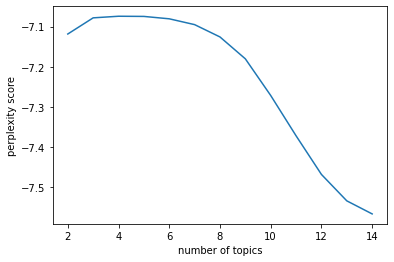

In [32]:
import matplotlib.pyplot as plt 
x = range(2,15)
plt.plot(x,perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

## Coherence

In [28]:
import gensim
from gensim.models import CoherenceModel

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [43:42<00:00, 201.72s/it]


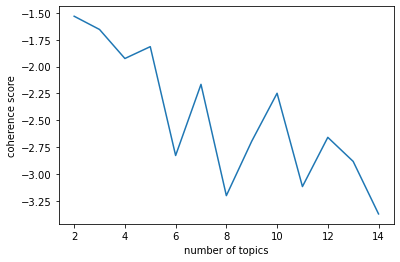

In [30]:
coherence_values=[]
for i in tqdm(range(2,15)):
    ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=i, iterations=400,passes = 20)
    #ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    #ldamodel = models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=99)
    #coherence_model_lda=CoherenceModel(model=ldamodel, texts=corpus, dictionary=dictionary, topn=10)
    coherence_model_lda=CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
x=range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

---